# RNN을 이용한 주식 종가 예측
이 노트북은 Open, High, Low 데이터를 기반으로 Close 값을 예측하는 RNN 모델을 구성합니다.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt


In [6]:

# 데이터 로드 및 전처리
df = pd.read_csv('./AAME.csv')
df = df[['Open', 'High', 'Low', 'Close']]
df = df[df['Open'] != 0.0].reset_index(drop=True)


In [7]:

# 정규화
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
features = df[['Open', 'High', 'Low']].values
targets = df['Close'].values.reshape(-1, 1)
features_scaled = scaler_x.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)


In [8]:

# 시계열 데이터 생성
n_timesteps = 10
X, y = [], []
for i in range(n_timesteps, len(features_scaled)):
    X.append(features_scaled[i-n_timesteps:i])
    y.append(targets_scaled[i])
X, y = np.array(X), np.array(y)


In [9]:

# 훈련/테스트 데이터 분리 (시계열이므로 시간 순서대로)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [10]:

# RNN 모델 구성
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(10, 3)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# 예측
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)


C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,465 (25.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 4.6398e-05
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2362e-04 - val_loss: 2.3674e-05
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9730e-04 - val_loss: 2.2590e-05
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5565e-04 - val_loss: 2.2941e-05
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7608e-04 - val_loss: 2.2176e-05
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7768e-04 - val_loss: 6.2208e-05
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4822e-04 - val_loss: 2.4173e-05
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3563e-04 - val_loss: 2.8699e-05
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6597e-04 - val_loss: 2.2683e-05
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7530e-04 - val_loss: 2.4684e-05
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.

In [11]:

# MAE 평가
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'📘 테스트 데이터 기준 RNN MAE: {mae:.4f}')


📘 테스트 데이터 기준 RNN MAE: 0.0936


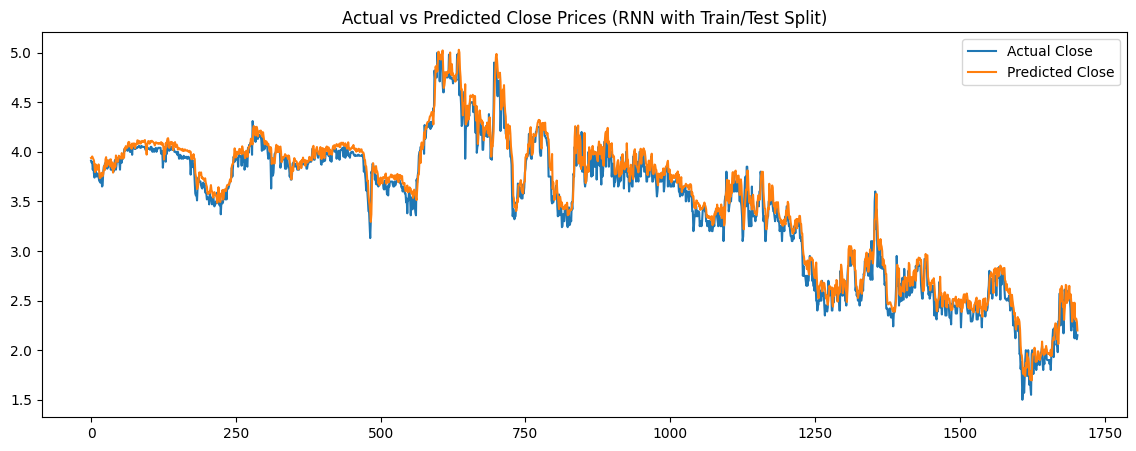

In [12]:

# 시각화
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices (RNN with Train/Test Split)')
plt.show()